# 機械学習入門
##  第4回の演習ノートブック [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isshiki/machine-learning-with-python/blob/main/04_lasso_ridge_regression/04_lasso_ridge_regression.ipynb)

- ＠IT連載： [『Pythonで学ぶ「機械学習」入門【知識ゼロでも大丈夫】』](https://atmarkit.itmedia.co.jp/ait/subtop/features/di/machinelearning_index.html)
- 対応記事： [「「正則化」手法（ラッソ回帰、リッジ回帰）をPythonで学ぼう」](https://atmarkit.itmedia.co.jp/ait/articles/2412/05/news00x.html)

このノートブックは、[Apache License 2.0ライセンス](https://opensource.org/license/apache-2-0)で提供しています。商用でも使用・改変・複製・再配布が可能です。詳細については、LICENSEファイルをご覧ください。

In [1]:
#@title 実行環境のバージョンチェック

# Pythonや各ライブラリのバージョンによって、Pythonコードの挙動が異なる可能性があります。
# そのため、サンプルノートブック作成時の実行環境と一致させられるよう、本連載で提供する全てのサンプルノートブックではバージョン情報を出力しています。

from datetime import datetime
import platform
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import statsmodels

print(f'実行日: {datetime.now():%Y年%m月%d日}')
print(f'Python version: {platform.python_version()}')
print(f'NumPy version: {np.version.version}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

# 実行日: 2024年12月02日
# Python version: 3.10.12
# NumPy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.8.0
# scikit-learn version: 1.5.2

実行日: 2024年12月03日
Python version: 3.10.12
NumPy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.8.0
scikit-learn version: 1.5.2


通常はこのインストール作業は不要です。各ライブラリーのバージョンを、本ノートブック作成時と一致させたい場合は、次のコマンドをコードセルに入力して再インストールしてください。コマンド実行には管理者権限が必要です。

```bash
! pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.0 scikit-learn==1.5.2
```

### ■体験してみよう

scikit-learnには、ラッソ回帰モデルを構築できる`Lasso`クラスと、リッジ回帰モデルを構築できる`Ridge`クラス（いずれも`sklearn.linear_model`モジュール）があります。

#### ●LassoクラスとRidgeクラスの使い方

```python
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso()
ridge_model = Ridge()

lasso_model.fit(＜特徴量：X＞, ＜ターゲット：y＞)
ridge_model.fit(＜特徴量：X＞, ＜ターゲット：y＞)

lasso_model.predict(＜新しいデータ＞)
ridge_model.predict(＜新しいデータ＞)
```

#### ●実際に使ってみよう： データセットの作成

今回は、scikit-learnの`make_regression()`関数を用いて、独自のデータセットを作成します。この関数の詳細な使い方について興味がある場合は、[公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)をご参照ください。


In [2]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 独自のデータセットを作成
data, target = make_regression(
    n_samples=500,     # データ数。この例では500個を生成
    n_features=6,      # 特徴量の数。この例では6つ作成
    n_informative=4,   # ターゲット値に影響を与える特徴量の数
    noise=1.0,         # ターゲット値に追加するノイズの標準偏差
    effective_rank=1,  # 値が小さいほど特徴量間の多重共線性が強くなる
    random_state=0     # 乱数のシード値。再現性のために指定
)

# 特徴量とターゲットの取得
X = data
y = target

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=0)

print(f'訓練セットのサイズ: {X_train.shape}')  # 訓練セットのサイズ: (450, 6)
print(f'テストセットのサイズ: {X_test.shape}')  # テストセットのサイズ: (50, 6)

訓練セットのサイズ: (450, 6)
テストセットのサイズ: (50, 6)


<a name="corr"></a>

##### ○相関行列のヒートマップ図

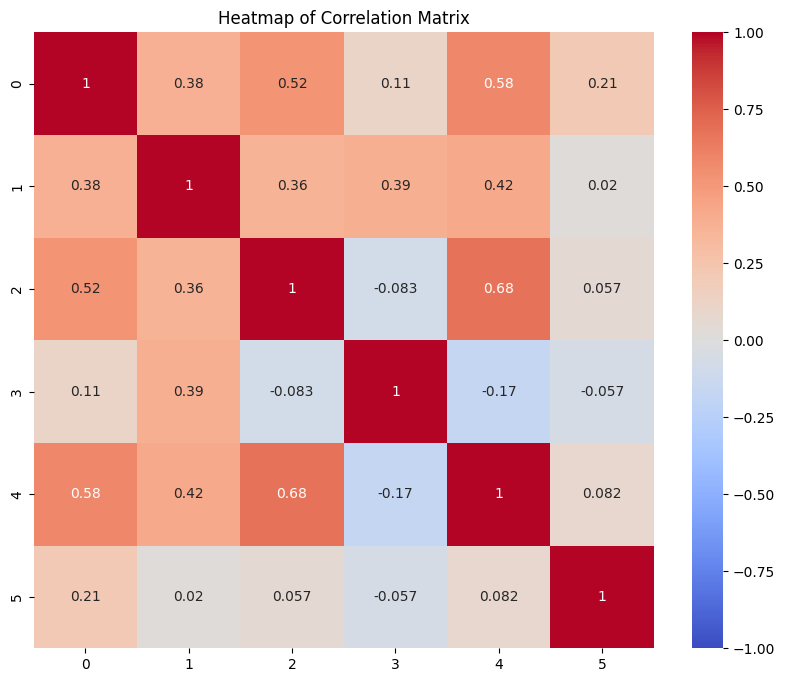

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練セットをpandas DataFrame化
X = pd.DataFrame(X_train)

# 相関行列の計算
corr_matrix = X.corr()

# 相関行列のヒートマップ図の表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

#### ●実際に使ってみよう： 機械学習モデルの訓練

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 線形回帰モデルの訓練
model = LinearRegression()
model.fit(X_train, y_train)

# ラッソ回帰モデルの訓練
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# リッジ回帰モデルの訓練
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# 各回帰モデルの訓練結果
print('線形回帰　の係数：', model.coef_)
print('ラッソ回帰の係数：', lasso_model.coef_)
print('リッジ回帰の係数：', ridge_model.coef_)
# 線形回帰　の係数： [0.90503157 0.00602306 0.02570293 1.38949469 0.77165554 0.51595936]
# ラッソ回帰の係数： [0.91500866 0.00436347 0.         1.26407406 0.66960111 0.41370818]
# リッジ回帰の係数： [0.90495996 0.00638464 0.02590128 1.38898153 0.7711575  0.51584978]

線形回帰　の係数： [0.90503157 0.00602306 0.02570293 1.38949469 0.77165554 0.51595936]
ラッソ回帰の係数： [0.91500866 0.00436347 0.         1.26407406 0.66960111 0.41370818]
リッジ回帰の係数： [0.90495996 0.00638464 0.02590128 1.38898153 0.7711575  0.51584978]


#### ●実際に使ってみよう： 訓練済みモデルによる予測

In [5]:
# テストセットを用いて予測
y_pred = model.predict(X_test)  # 線形回帰
lasso_y_pred = lasso_model.predict(X_test)  # ラッソ回帰
ridge_y_pred = ridge_model.predict(X_test)  # リッジ回帰

# 先頭の5行を出力してみる
print(f'実際　のターゲット（先頭5行）:{y_test[:5]}')
print(f'線形回帰　の予測値（先頭5行）:{y_pred[:5]}')
print(f'ラッソ回帰の予測値（先頭5行）:{lasso_y_pred[:5]}')
print(f'リッジ回帰の予測値（先頭5行）:{ridge_y_pred[:5]}')
# 実際　のターゲット（先頭5行）:[ 1.11476512  0.45862537  0.21266336  2.47469281 -2.61062525]
# 線形回帰　の予測値（先頭5行）:[-0.84625175  0.41405646 -0.01181898  3.07317956 -0.99385849]
# ラッソ回帰の予測値（先頭5行）:[-0.84676734  0.37430817  0.06661403  2.68987944 -0.9196915 ]
# リッジ回帰の予測値（先頭5行）:[-0.84617638  0.41454519 -0.01158544  3.07259086 -0.99293168]

実際　のターゲット（先頭5行）:[ 1.11476512  0.45862537  0.21266336  2.47469281 -2.61062525]
線形回帰　の予測値（先頭5行）:[-0.84625175  0.41405646 -0.01181898  3.07317956 -0.99385849]
ラッソ回帰の予測値（先頭5行）:[-0.84676734  0.37430817  0.06661403  2.68987944 -0.9196915 ]
リッジ回帰の予測値（先頭5行）:[-0.84617638  0.41454519 -0.01158544  3.07259086 -0.99293168]


#### ●モデルの評価と考察

In [6]:
from sklearn.metrics import r2_score

# R^2スコア（決定係数）の計算
r2 = r2_score(y_test, y_pred)  # 線形回帰
lasso_r2 = r2_score(y_test, lasso_y_pred)  # ラッソ回帰
ridge_r2 = r2_score(y_test, ridge_y_pred)  # リッジ回帰

# モデルの評価
print(f'線形回帰　のR^2スコア: {r2:.5f}')
print(f'ラッソ回帰のR^2スコア: {lasso_r2:.5f}')
print(f'リッジ回帰のR^2スコア: {ridge_r2:.5f}')
# 線形回帰　のR^2スコア: 0.78063
# ラッソ回帰のR^2スコア: 0.78298
# リッジ回帰のR^2スコア: 0.78065

線形回帰　のR^2スコア: 0.78063
ラッソ回帰のR^2スコア: 0.78298
リッジ回帰のR^2スコア: 0.78065


### ■【発展】ハイパーパラメーターのチューニング（初級編）

#### ●GridSearchCVクラスを用いる方法

In [7]:
from sklearn.model_selection import GridSearchCV

# チューニングするハイパーパラメーター「α」の候補値
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# GridSearchCVの動作内容を設定
grid_search = GridSearchCV(
    estimator=ridge_model,  # リッジ回帰モデル
    param_grid=param_grid,  # 候補値
    scoring='r2')  # R^2スコアを評価指標に指定

# 最適なハイパーパラメーター値を確定させる
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメーター値を出力
print("リッジ回帰の最適なalpha値:", grid_search.best_params_['alpha'])
# リッジ回帰の最適なalpha値: 1

リッジ回帰の最適なalpha値: 1


<a name="tuning"></a>

##### ○最適なハイパーパラメーター値を指定した結果

In [8]:
ridge_model2 = Ridge(alpha=1.0)
ridge_model2.fit(X_train, y_train)
ridge_y_pred2 = ridge_model2.predict(X_test)
ridge_r2_2 = r2_score(y_test, ridge_y_pred2)
print(f'線形回帰　のR^2スコア: {r2:.5f}')
print(f'リッジ回帰（α=0.1）のR^2スコア: {ridge_r2:.5f}')
print(f'リッジ回帰（α=1.0）のR^2スコア: {ridge_r2_2:.5f}')
# 線形回帰　のR^2スコア: 0.78063
# リッジ回帰（α=0.1）のR^2スコア: 0.78065
# リッジ回帰（α=1.0）のR^2スコア: 0.78080

線形回帰　のR^2スコア: 0.78063
リッジ回帰（α=0.1）のR^2スコア: 0.78065
リッジ回帰（α=1.0）のR^2スコア: 0.78080


### 今回は、これで終わりです。お疲れさまでした。

---

### ■【参考】本稿に掲載した図版のコード

以下に、本稿で使用した図版を作成するためのコードを参考として掲載しています。記事の理解には必要ありませんが、興味がある方は参考にしてください。

図版で日本語を使用しているため、以下のインストールとインポートが必要です。

In [9]:
! pip install japanize-matplotlib

In [10]:
import japanize_matplotlib

#### 図8　仕組みの理解： 絶対値と2乗値の特性を比較

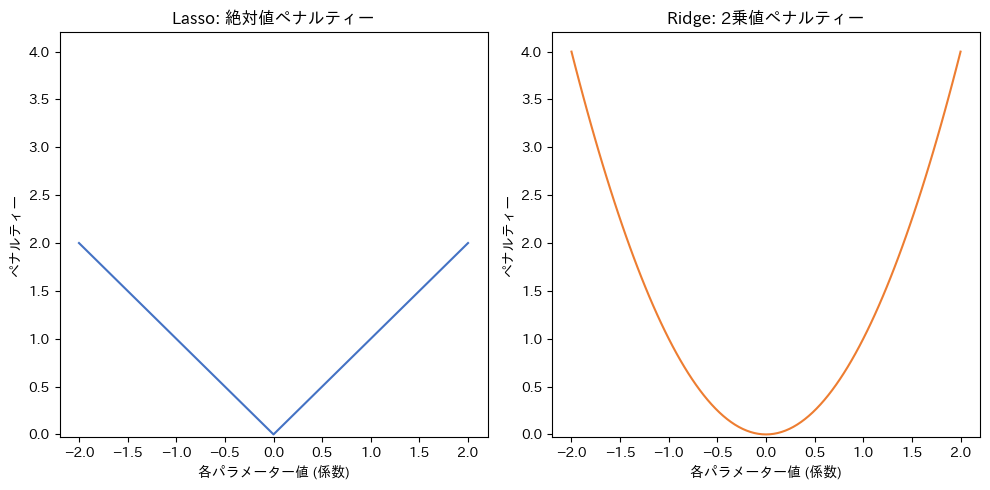

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# グラフ設定
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
weights = np.linspace(-2, 2, 101)
# print(weights)

# Lassoペナルティー
def lasso_penalty(w):
    return np.abs(w)

# Ridgeペナルティー
def ridge_penalty(w):
    return w**2

lasso_penalties = [lasso_penalty(w) for w in weights]
ridge_penalties = [ridge_penalty(w) for w in weights]

# サブプロット1: Lasso回帰
axes[0].plot(weights, lasso_penalties, label='Lasso (L1)', color='#4472C4')
axes[0].set_title('Lasso: 絶対値ペナルティー')
axes[0].set_xlabel('各パラメーター値 (係数)')
axes[0].set_ylabel('ペナルティー')
axes[0].set_xlim(-2.2, 2.2)
axes[0].set_ylim(-0.03, 4.2)

# サブプロット2: Ridge回帰
axes[1].plot(weights, ridge_penalties, label='Ridge (L2)', color='#ED7D31')
axes[1].set_title('Ridge: 2乗値ペナルティー')
axes[1].set_xlabel('各パラメーター値 (係数)')
axes[1].set_ylabel('ペナルティー')
axes[1].set_xlim(-2.2, 2.2)
axes[1].set_ylim(-0.03, 4.2)

# レイアウト調整
plt.tight_layout()
plt.show()